In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

### Getting mock data for testing

In [2]:
df = pd.read_csv('/home/astroguy/Desktop/research/research_emannuele/init_coh_search_algthm/sim_pulse_01.txt', delimiter = '    ')
df.head()

,time_sec,intensity
0,0.000000,0.316162
1,0.003662,0.728027
2,0.007325,-0.100037
3,0.010987,0.090271
4,0.014649,0.344971


### Constant acceleration model eqn (1)

In [3]:
rest_phase = np.arange(0, (np.pi*9)/4, np.pi/4)     # rest phase phi_0 in eqn below values taken from 
                                                    # (0 to 2pi) with an interval of pi/4
time = df['time_sec']        
freq = np.arange(1,10,1)                            # frequency omega_0 taken from (0 to 12)Hz at an interval 
                                                    # of 1.5Hz
acceleration = 0                                    # acceleration parameter alpha in the eqn below

Equation 1 in K smith(2016). 
$$ \phi(t) = \phi_{0} + \omega_{0}t + \frac{1}{2}\alpha t^2$$

In [4]:
def pulse_phase(p0,t,w0,a):
    '''
    This function calculates and returns pulse phase at any given time 't' when acceleration 'a', intial 
    phase 'p0' and angular frequency 'w0' is known.
    '''
    phase = p0 + w0*t + 0.5*a*t**2
    return phase

phase_calculation = []
for ind1 in np.arange(len(freq)):
    phase_val = pulse_phase(rest_phase[ind1], time, freq[ind1], acceleration)
    phase_calculation.append(phase_val)

In [12]:
phase_calculation[8]

0          6.283185
1          6.316143
2          6.349110
3          6.382068
4          6.415026
            ...    
16379    546.151344
16380    546.184302
16381    546.217260
16382    546.250227
16383    546.283185
Name: time_sec, Length: 16384, dtype: float64

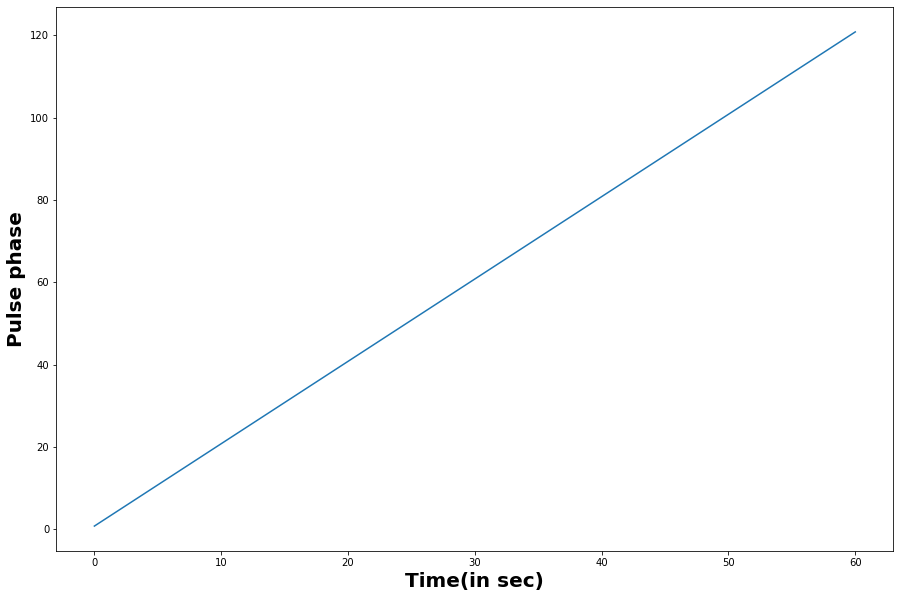

In [40]:
fig, pulse = plt.subplots(figsize = (15,10))
x1 = t
y1 = phase_calculation[1]  # There are 9 different parameters for phase0 and freq(w0). Just picked one of them.
pulse.plot(x1,y1)
pulse.set_xlabel('Time(in sec)', fontsize = 20, weight = 'bold')
pulse.set_ylabel('Pulse phase', fontsize = 20, weight = 'bold')
plt.show()

# From the eqution 1 above for alpha is 0 we expect linear equation for phase. Plot below shows one of this

### Von-Mises profile eqn (2)

Von Mises profile can be obtained from the euqtion(Eqn 2, K Smith)

$$ \rho(\phi) = e^{-2\kappa(sin^2(\phi/2))}$$

where $$\kappa = \frac{log(2)}{2sin^2{(\pi D/2)}}$$

In [14]:
def von_mises_profile(angle,duty):
    '''
    This function calculates von_mises profile based on duty cycle obtained from previous kappa function.
    For the vlue of pulse_phase it makes a call from pulse_phase function defined above
    '''
    k = (np.log(2))/(2*(np.sin((np.pi*duty)/2))**2)
    
    y = np.exp(-2*k*(np.sin(angle/2))**2)
    
    return y

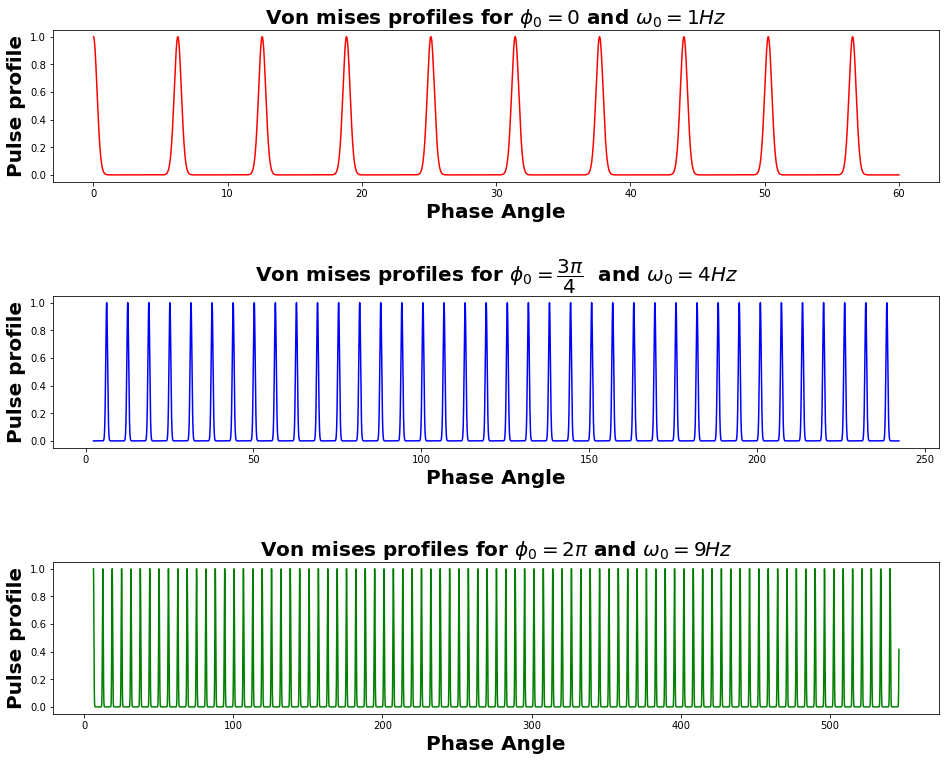

In [15]:
# Here, I am planning to show comparative plot of von mises profile for different combination values of phase
# and frequency. Among 9 different values, I will pick (phase, frequency) combination of (0,1Hz), (3pi/4, 4Hz)
# and (2pi, 9Hz). I have chosen duty cycle of 10% to calculate K parameter.
    
    
for ind2 in np.arange(9):

    if ind2 == 0:
        x2 = phase_calculation[ind2]
        y2 = von_mises_profile(x2, 0.1) 
        

    elif ind2 == 3:
        x3 = phase_calculation[ind2]
        y3 = von_mises_profile(x3, 0.1) 


    elif ind2 == 8:
        x4 = phase_calculation[ind2]
        y4 = von_mises_profile(x4, 0.1) 


fig, von_mises = plt.subplots(nrows=3, figsize = (15,12))
von_mises[0].plot(x2, y2,'r')
von_mises[0].set_xlabel('Phase Angle', fontsize = 20, weight = 'bold')
von_mises[0].set_ylabel('Pulse profile', fontsize = 20, weight = 'bold')
von_mises[0].set_title('Von mises profiles for $\phi_{0} = 0$ and $\omega_{0} = 1Hz$',fontsize = 20, weight = 'bold')
fig.tight_layout(pad = 7)
von_mises[1].plot(x3, y3,'b')
von_mises[1].set_xlabel('Phase Angle', fontsize = 20, weight = 'bold')
von_mises[1].set_ylabel('Pulse profile', fontsize = 20, weight = 'bold')
von_mises[1].set_title('Von mises profiles for $\phi_{0} = \dfrac{3\pi}{4}$  and $\omega_{0} = 4Hz$',fontsize = 20, weight = 'bold')

von_mises[2].plot(x4, y4,'g')
von_mises[2].set_xlabel('Phase Angle', fontsize = 20, weight = 'bold')
von_mises[2].set_ylabel('Pulse profile', fontsize = 20, weight = 'bold')
von_mises[2].set_title('Von mises profiles for $\phi_{0} = 2\pi$ and $\omega_{0} = 9Hz$',fontsize = 20, weight = 'bold')

plt.savefig('/home/astroguy/Desktop/research/research_emannuele/init_coh_search_algthm/Pulse_profile.pdf')
plt.show()


### Detection statistic (5)

Intensity time stream $I(t) = \rho(\phi(t))$. So, ignoring the downsampling for now, we just take intensity time stream to be values calculated from von-mises funtion above. But we use normalization condition to find '$\eta$' (noize parameter) using the equation(eqn 4 in Smith K) below.

$$ \eta^{-2} t_{s} \sum_{k=0}^{N-1} (I_{k})^2 = 1$$ 

So rearranging we get,
$$ \eta^{-2} = \frac{1}{t_{s} \sum_{k=0}^{N-1}(I_{k})^2} $$

We can use this to find the detection statistic using equation below. 

$$ \hat{\epsilon} = \eta^{-2} t_{s} \sum_{k=0}^{N-1} d_{k}I_{k} $$

In [16]:
eta_negativesquared = lambda phaseval, sample_time: 1/(sample_time*np.sum((von_mises_profile(phaseval, 0.1))**2))

def detection_statistic(sampletime, datastream, phaseangle):
    '''
    This function calculates the detection statistic (eqn 5, K smith). Function arguments dk and ik are data 
    timestream and intensity timestream that we suuply as lists.d_k is intensity data in the table above and 
    I_k is von_mises profile calculated for various phase angle. Phase angle itself if calculated from pulse_
    phase function for the time series. This furnction returns detection statistic value as an output.
    '''
    dk = datastream
    eta_value = eta_negativesquared(phaseangle,sampletime)
    I_k = von_mises_profile(phaseangle,0.1)
    sum_dk_ik =  0
    
    for i in np.arange(len(df['time_sec'])):
        
        val1 = dk[i]*I_k[i]
        sum_dk_ik +=val1
        
    det_stat = sampletime*eta_value*sum_dk_ik
    return det_stat


In [22]:
det_stat_value = []

for index1 in np.arange(9):
    det_value = detection_statistic(0.005, df['intensity'], phase_calculation[index1])
    det_stat_value.append(det_value)

In [23]:
data = {'Phase': rest_phase, 'Frequency(Hz)': freq, 'Detection_Statistic': det_stat_value}
pd.DataFrame(data, index=np.arange(1,10,1))


,Phase,Frequency(Hz),Detection_Statistic
1,0.000000,1,0.456982
2,0.785398,2,0.458164
3,1.570796,3,0.455208
4,2.356194,4,0.432787
5,3.141593,5,0.438081
6,3.926991,6,0.451293
7,4.712389,7,0.473283
8,5.497787,8,0.436554
9,6.283185,9,0.456641
